Comparing methods for dynamic functional connectivity in brain imaging
--
This notebook implements decomposition methods such as ICA and dictionary learning

In [5]:
import numpy as np 

import os 

datapath = 'D:/OHBM/dynamic'

from matplotlib import pyplot as plt 

%matplotlib inline

from nilearn.plotting import plot_matrix, plot_connectome


The following cell extracts the baricenters of the regions from the atlas and creates a 3 x 93 arrays of ROI center coordinates 

In [6]:
# Current ATLAS  
roi_maps = 'D:/OHBM/dynamic/basc_2mm_scale064.nii.gz'

from nilearn.plotting import plot_prob_atlas,plot_roi
from nilearn.regions import connected_label_regions

labels_maps = connected_label_regions(roi_maps)

from nilearn.image import math_img
from nilearn.image import iter_img

from nilearn.plotting import find_xyz_cut_coords

nrois = np.unique(labels_maps.get_data())[-1]

roi_maps_4D = []

for i in range(1,nrois+1):
    curimg = math_img('img == %d' % i ,img=labels_maps)
    roi_maps_4D.append(curimg)
    

coords_connectome = [find_xyz_cut_coords(img) for img in iter_img(roi_maps_4D)]
coords_connectome = np.stack(coords_connectome)


Load FC matrices

In [18]:
all_FC_sl = np.load(os.path.join(datapath,'FC_matrices_10.npz'))['FCmatrices']

In [20]:
all_FC_sl.shape

(40, 572, 4278)

# ICA

Compute ICA on FC matrices (which are reshaped into: (N subjects * N of sliding windows)* N of regions))

In [21]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components = 5)
weights = ica.fit_transform(all_FC_sl.reshape((all_FC_sl.shape[0]*all_FC_sl.shape[1],all_FC_sl.shape[2])))

Reshape weights of the five components into back in the matrix format

In [23]:
weights = weights.reshape((all_FC_sl.shape[0],all_FC_sl.shape[1],5))

Plot the timecourses of the weights

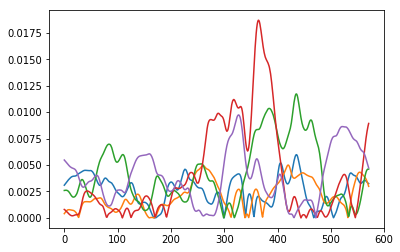

In [26]:
plt.plot(abs(weights[0]))

Save the components to the local storage

In [27]:
np.savez_compressed(os.path.join(datapath,'ICA_components.npz'),ica)

Visualisation of each of the components within a matrix

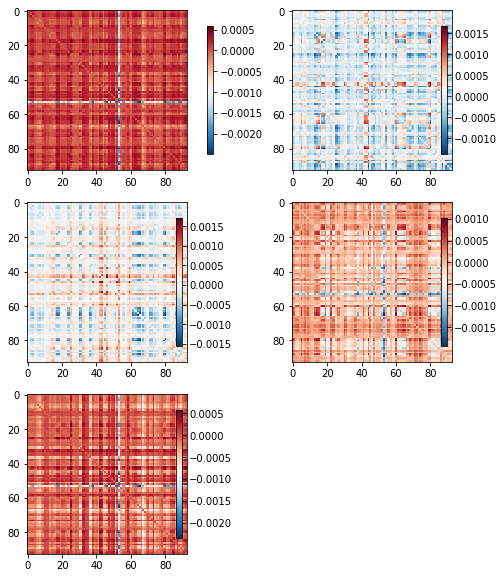

In [28]:
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec

components_matrix = np.ndarray((ica.components_.shape[0],93,93))

plt.figure(figsize=(10,10))
for i in range(ica.components_.shape[0]):
    components_matrix[i] = vec_to_sym_matrix(ica.components_[i],diagonal=np.zeros(93))
    ax = plt.subplot(3,2,i+1)
    plot_matrix(components_matrix[i],axes=ax)

Visualisation of the components on glass brains

In [29]:
# Current ATLAS  
roi_maps = 'D:/OHBM/dynamic/basc_2mm_scale064.nii.gz'

from nilearn.plotting import plot_prob_atlas,plot_roi
from nilearn.regions import connected_label_regions

nrois = np.unique(labels_maps.get_data())[-1]

In [30]:
from nilearn.image import math_img
from nilearn.image import iter_img

from nilearn.plotting import find_xyz_cut_coords


roi_maps_4D = []

for i in range(1,nrois+1):
    curimg = math_img('img == %d' % i ,img=labels_maps)
    roi_maps_4D.append(curimg)
    

coords_connectome = [find_xyz_cut_coords(img) for img in iter_img(roi_maps_4D)]
coords_connectome = np.stack(coords_connectome)

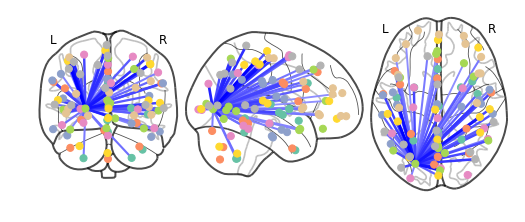

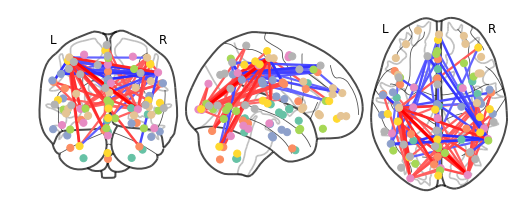

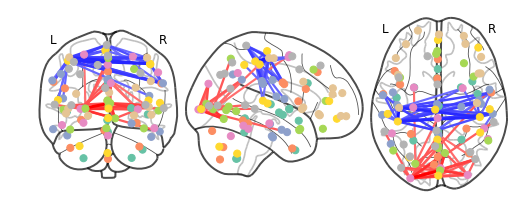

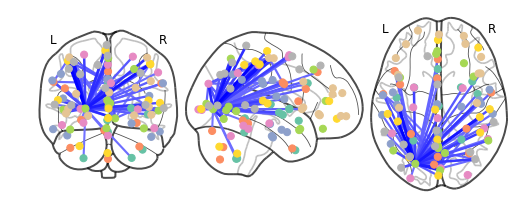

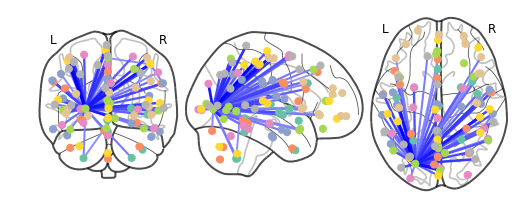

In [31]:
from nilearn.plotting import plot_connectome 

for i in range(ica.components_.shape[0]):
    curA = (components_matrix[i])
    plot_connectome(curA,coords_connectome,edge_threshold='98.5%')
    plt.show()

# Next steps:
- integrate dictionary learning?
- re-do FC matrices and ICA on data-driven networks?